<a href="https://colab.research.google.com/github/CienciaDatosUdea/002_EstudiantesAprendizajeEstadistico/blob/main/semestre2025-2/Laboratorios/Laboratorio_07_nn_zeroV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Data

In [1]:
import pandas as pd
import scipy as sc
import numpy as np
import h5py
import matplotlib.pylab as plt

In [2]:
data_train= r"./../Data/train_catvnoncat.h5"
train_dataset = h5py.File(data_train, "r")

data_test= "./../Data/test_catvnoncat.h5"
test_dataset = h5py.File(data_test, "r")

In [3]:
train_dataset.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [4]:
# Read the data
xtrain_classes, xtrain, train_label =\
    train_dataset["list_classes"],train_dataset["train_set_x"],train_dataset["train_set_y"]

test_classes, xtest, test_label =\
    test_dataset["list_classes"],test_dataset["test_set_x"],test_dataset["test_set_y"]

xtrain_classes[:]



array([b'non-cat', b'cat'], dtype='|S7')

In [5]:
np.shape(xtrain)

(209, 64, 64, 3)

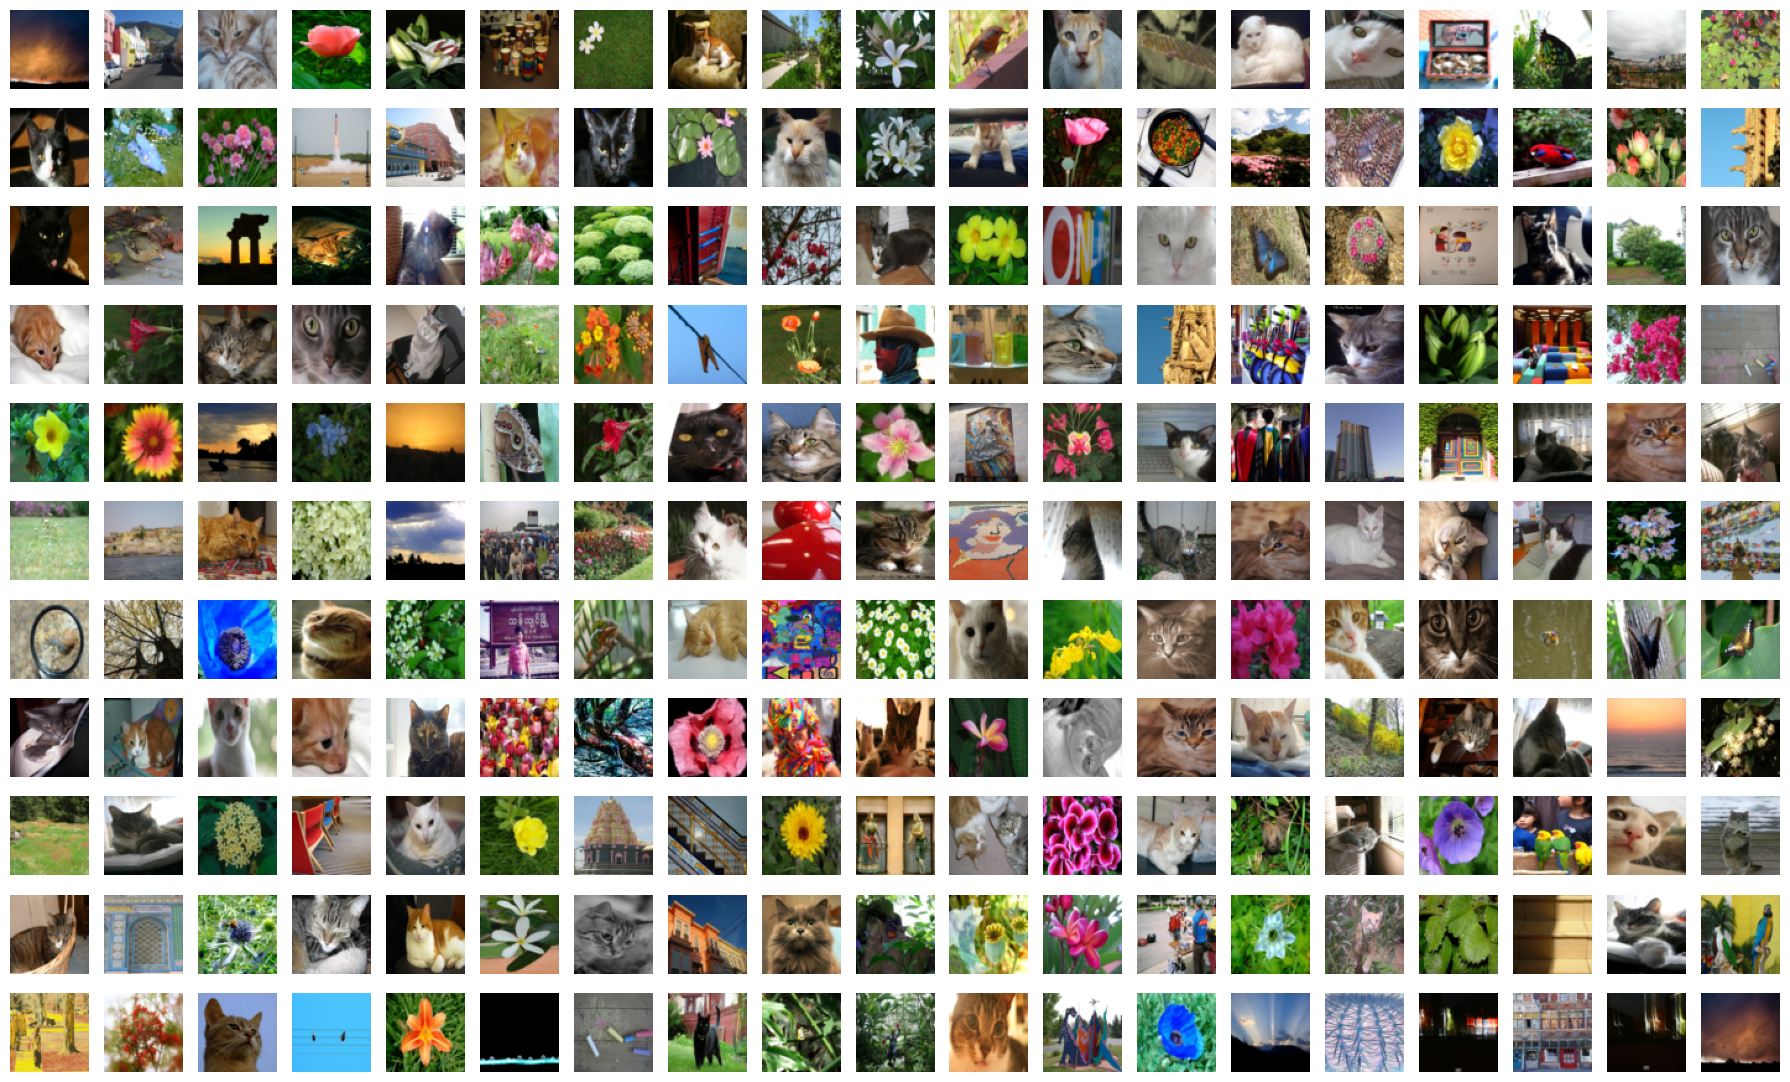

In [6]:

# Total de imágenes
n_imgs = 209

# Configura la cuadrícula (por ejemplo, 19 columnas x 11 filas)
cols = 19
rows = int(np.ceil(n_imgs / cols))

plt.figure(figsize=(18, 11))

for i in range(n_imgs):
    # Recupera la imagen i-ésima
    img = xtrain[i]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
np.shape(xtrain[0])

(64, 64, 3)

In [8]:
np.reshape(xtrain[0], 64*64*3)

array([17, 31, 56, ...,  0,  0,  0], dtype=uint8)

In [9]:
xtrain_= np.reshape(xtrain,(209, 64*64*3))/255
xtest_ = np.reshape(xtest,(50, 64*64*3))/255

In [10]:
len(xtrain_[208])

12288

# NN


In [12]:
import numpy as np

# Funciones de activación 
def act_function(x, activation):
    if activation == "sigmoid":
        return 1 / (1 + np.exp(-x))

    elif activation == "tanh":
        return np.tanh(x)

    elif activation == "relu":
        return np.maximum(0, x)

    elif activation == "linear" or activation is None:
        return x

    else:
        raise ValueError(f"Activación desconocida: {activation}")

# Derivada analítica 
def d_act_function(x, activation):
    if activation == "sigmoid":
        s = 1 / (1 + np.exp(-x))
        return s * (1 - s)
    
    elif activation == "tanh":
        t = np.tanh(x)
        return 1 - t**2
    
    elif activation == "relu":
        return (x > 0).astype(float)
    
    elif activation == "linear" or activation is None:
        return np.ones_like(x)
    
    else:
        raise ValueError(f"Derivada desconocida para activación: {activation}")


def binary_cross_entropy(y_pred, y_true):
    eps = 1e-8
    m = y_true.shape[1]
    return -1/m * np.sum(
        y_true * np.log(y_pred + eps) +
        (1 - y_true) * np.log(1 - y_pred + eps)
    )

def d_binary_cross_entropy(y_pred, y_true):
    m = y_true.shape[1]
    return (y_pred - y_true) / m   # derivada simplificada

In [ ]:

# Cada capa almacena los pesos y biases asociados a esa capa
class Layer:
    def __init__(self):
        pass

class Dense(Layer):
    def __init__(self, n_neurons, activation):
        super().__init__()
        self.units = n_neurons
        self.activation = activation
        self.W = None
        self.b = None
    
    def build(self, input_shape):
        # Initialize weights and biases based on a know architecture
        self.W = np.random.randn(self.units, input_shape) * 0.01
        self.b = np.zeros((self.units, 1))

    def forward(self, X):
        self.X_input = X # Antes de activar
        self.Z = self.W @ X + self.b
        return act_function(self.Z, self.activation)

    def backward(self, dA, learning_rate):
        # dz = dA * f'(z)
        d_act = d_act_function(self.Z, self.activation)
        dZ = dA * d_act

        m = self.X_input.shape[1]
        
        # Gradiente de pesos y bias
        dW = (1/m) * dZ @ self.X_input.T
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        # Propagación hacia atrás
        dA_prev = self.W.T @ dZ

        # Actualización de parametros 
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        
        # Devolver el gradiente para la capa anterior
        return dA_prev


class Flatten(Layer):
    # Aplana la matriz de entrada en un vector
    def __init__(self, input_shape):
        """input_shape: array-like, shape of the input data (height, width, channels)"""
        super().__init__()
        self.original_shape = input_shape
        self.input_shape = np.prod(input_shape)
    
    def build(self, input_shape):
        pass

    def forward(self, X):
        X = np.asarray(X).flatten().reshape(-1, 1)
        return X

    def backward(self, dA, learning_rate=None):
        return dA

In [ ]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

        self.build()
    
    # Método constructor para inicializar hiperparámetros de las capas
    def build(self):
        n_input = None
        for layer in self.layers:
            if isinstance(layer, Flatten):
                n_input = layer.input_shape
            elif isinstance(layer, Dense):
                layer.build(n_input)
                n_input = layer.units

    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out
        # return out

    # Método para entrenar la red con backpropagation (cada capa actualiza los pesos y los biases)
    def fit(self, X, Y, loss_function, d_loss_function,
        learning_rate=0.01, max_iter=1000, verbose=True):

        m = X.shape[0]

        for epoch in range(max_iter):
            for i in range(m):
                x_i = X[i:i+1].T
                y_i = np.array([[Y[i]]])

                y_pred = self.forward(x_i)
                loss = loss_function(y_pred, y_i)
                dA = d_loss_function(y_pred, y_i)

                for layer in reversed(self.layers):
                    dA = layer.backward(dA, learning_rate)
            # if verbose:print(epoch)
            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch} - Loss = {loss:.6f}")

                
    def predict(self, X):
        # IA hint. hacer las predicciones sobre cada dato 
        X = np.asarray(X)
        predictions = []
        for i in range(X.shape[0]):
            x_i = X[i:i+1].T
            y_pred = self.forward(x_i)
            predictions.append(y_pred[0, 0])
        return np.array(predictions)
    

In [25]:
# Asegurar que train_label y test_label sean arrays 1D
train_label = np.array(train_label).flatten()
test_label = np.array(test_label).flatten()

# Crear el modelo
model = Sequential([
    Flatten(input_shape=(64, 64, 3)), 
    Dense(128, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(1, activation='sigmoid')
])

# Entrenar el modelo
model.fit(xtrain, train_label, 
          loss_function=binary_cross_entropy, 
          d_loss_function=d_binary_cross_entropy,
          learning_rate=0.01, 
          max_iter=10, 
          verbose=True)

Epoch 0 - Loss = 0.654303


In [26]:
def evaluate_model(model, X, y, loss_function=None, threshold=0.5):
    y_pred_proba = model.predict(X)
    y_pred = (y_pred_proba > threshold).astype(int)
    y = np.array(y).flatten()
    accuracy = np.mean(y_pred == y)
    
    loss = None
    if loss_function is not None:
        total_loss = 0
        for i in range(len(y)):
            total_loss += loss_function(np.array([[y_pred_proba[i]]]), np.array([[y[i]]]))
        loss = total_loss / len(y)
    
    return {'accuracy': accuracy, 'predictions': y_pred, 'probabilities': y_pred_proba, 'loss': loss}

train_results = evaluate_model(model, xtrain, train_label, loss_function=binary_cross_entropy)
print(f"Train - Accuracy: {train_results['accuracy']:.4f}, Loss: {train_results['loss']:.6f}")

test_results = evaluate_model(model, xtest, test_label, loss_function=binary_cross_entropy)
print(f"Test - Accuracy: {test_results['accuracy']:.4f}, Loss: {test_results['loss']:.6f}")



Train - Accuracy: 0.6555, Loss: 0.646126
Test - Accuracy: 0.3400, Loss: 0.803671
